In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


In [2]:
import os
import random
import re
import numpy as np
import pandas as pd
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from nltk.corpus import stopwords
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn import metrics
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# For reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [4]:
# Hyperparameters
vocab_size = 160_000
embedding_dim = 300
hidden_dim = 128
n_layers = 2
seq_len = 2000
learning_rate = 0.0025
max_epochs = 10
batch_size = 40

# Data loading and preprocessing

In [5]:
# Read data
real = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")
fake = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")

# Create labels
real["label"] = 1
fake["label"] = 0

# Combine and shuffle
combined = pd.concat([fake, real], axis=0)
combined = combined.sample(frac=1).reset_index(drop=True)

# Split dataset into train, val and test with a ratio of 80-10-10
train = combined[:int(0.8 * len(combined))]
val = combined[int(0.8 * len(combined)):int(0.9 * len(combined))]
test = combined[int(0.9 * len(combined)):]

In [6]:
train.shape, val.shape, test.shape

((35918, 5), (4490, 5), (4490, 5))

In [7]:
def build_vocabulary():
    train_iterator = list(zip(train['text'], train['label']))
    tokenizer = get_tokenizer("basic_english")

    def tokenizer_fn(data_iterator):
        for text, _ in data_iterator:
            yield tokenizer(text)

    vocab = build_vocab_from_iterator(tokenizer_fn(train_iterator), specials=["<unk>"])
    vocab.set_default_index(vocab["<unk>"])

    return vocab, tokenizer

def clean_text(dataframe):
    dataframe["text"] = dataframe["subject"] + " " + dataframe["title"] + " " + dataframe["text"]

    del dataframe['title']
    del dataframe['subject']
    del dataframe['date']

    stop_words = list(set(stopwords.words('english')))

    def _process_text(text):
        text = text.lower()
        text = " ".join([word for word in text.split() if word not in stop_words])
        text = re.sub(r"[^\w\s]", '', text)
        return text

    dataframe['text'] = dataframe['text'].apply(_process_text)

    return dataframe


def tokenize_text(dataframe, vocab, tokenizer):
    dataframe["text"] = dataframe["text"].apply(lambda x: np.array(vocab(tokenizer(x)), dtype=np.int64))
    return dataframe[['text', 'label']]


def pad_tokens(dataframe, vocab, max_len):
    dataframe['text'] = dataframe['text'].apply(
        lambda x: np.pad(x, (0, max(0, max_len - len(x))), 'constant', constant_values=vocab["<unk>"]))
    dataframe["text"] = dataframe["text"].apply(lambda x: x[:max_len])
    return dataframe

def create_dataloader(dataframe, vocab, tokenizer, seq_len, batch_size):
    dataframe = clean_text(dataframe)
    dataframe = tokenize_text(dataframe, vocab, tokenizer)
    dataframe = pad_tokens(dataframe=dataframe, vocab=vocab, max_len=seq_len)

    dataset = TensorDataset(
        torch.from_numpy(np.vstack(dataframe["text"].values)),
        torch.from_numpy(dataframe["label"].values)
    )

    return DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=1
    )

vocab, tokenizer = build_vocabulary()

train_dataloader = create_dataloader(
    dataframe=train, 
    vocab=vocab, 
    tokenizer=tokenizer, 
    seq_len=seq_len, 
    batch_size=batch_size
)

val_dataloader = create_dataloader(
    dataframe=val, 
    vocab=vocab, 
    tokenizer=tokenizer, 
    seq_len=seq_len, 
    batch_size=batch_size
)

test_dataloader = create_dataloader(
    dataframe=test, 
    vocab=vocab, 
    tokenizer=tokenizer, 
    seq_len=seq_len, 
    batch_size=batch_size
)

# Trainer

In [8]:
class Trainer:
    def __init__(self, model, train_dataloader, val_dataloader, test_dataloader, device, criterion, optimizer):
        self.model = model
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.test_dataloader = test_dataloader
        self.device = device
        self.criterion = criterion
        self.optimizer = optimizer

    def train(self, current_epoch_nr):
        self.model.train()

        num_batches = len(self.train_dataloader)

        preds = []
        targets = []
        correct = 0
        running_loss = 0.0
        items_processed = 0

        loop = tqdm(enumerate(self.train_dataloader), total=num_batches)
        for idx, (x, y) in loop:
            x = x.to(self.device)
            y = y.to(self.device)

            y_hat = self.model(x)

            loss = self.criterion(y_hat, y)
            loss.backward()

            self.optimizer.step()
            self.optimizer.zero_grad()

            running_loss += loss.item()

            _, predicted = y_hat.max(1)
            items_processed += y.size(0)
            correct += predicted.eq(y).sum().item()

            targets.extend(y.detach().cpu().numpy().flatten())
            preds.extend(predicted.detach().cpu().numpy().flatten())

            loop.set_description(f'Epoch {current_epoch_nr + 1}')
            loop.set_postfix(train_acc=round(correct / items_processed, 4),
                             train_loss=round(running_loss / items_processed, 4))

        train_auc = metrics.roc_auc_score(targets, preds)
        train_accuracy = correct / items_processed
        train_loss = running_loss / items_processed
        
        return train_auc, train_accuracy, train_loss

    def evaluate(self, current_epoch_nr, scheduler):
        self.model.eval()

        num_batches = len(self.val_dataloader)

        preds = []
        targets = []
        correct = 0
        running_loss = 0.0
        items_processed = 0

        with torch.no_grad():
            loop = tqdm(enumerate(self.val_dataloader), total=num_batches)
            for idx, (x, y) in loop:
                x = x.to(self.device)
                y = y.to(self.device)

                y_hat = self.model(x)

                loss = self.criterion(y_hat, y)

                running_loss += loss.item()

                _, predicted = y_hat.max(1)
                items_processed += y.size(0)
                correct += predicted.eq(y).sum().item()

                targets.extend(y.detach().cpu().numpy().flatten())
                preds.extend(predicted.detach().cpu().numpy().flatten())

                loop.set_description(f'Epoch {current_epoch_nr + 1}')
                loop.set_postfix(val_acc=round(correct / items_processed, 4),
                                 val_loss=round(running_loss / items_processed, 4))

        val_auc = metrics.roc_auc_score(targets, preds)
        validation_accuracy = correct / items_processed
        validation_loss = running_loss / num_batches

        scheduler.step(validation_accuracy)
        
        return val_auc, validation_accuracy, validation_loss

    def test(self):
        self.model.eval()

        num_batches = len(self.test_dataloader)

        preds = []
        targets = []
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            loop = tqdm(enumerate(self.test_dataloader), total=num_batches)
            for idx, (x, y) in loop:
                x = x.to(self.device)
                y = y.to(self.device)

                y_hat = self.model(x)

                loss = self.criterion(y_hat, y)

                running_loss += loss.item()

                _, predicted = y_hat.max(1)
                total += y.size(0)
                correct += predicted.eq(y).sum().item()

                targets.extend(y.detach().cpu().numpy().flatten())
                preds.extend(predicted.detach().cpu().numpy().flatten())

                loop.set_description('Testing')
                loop.set_postfix(test_acc=round(correct / total, 4),
                                 test_loss=round(running_loss / total, 4))

        test_auc = metrics.roc_auc_score(targets, preds)
        test_accuracy = correct / total
        test_loss = running_loss / num_batches
        
        return test_auc, test_accuracy, test_loss

# Model

In [9]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, seq_len):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)
        self.fc = nn.Linear(seq_len * hidden_dim, 2)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = torch.reshape(x, (x.size(0), -1,))
        x = self.fc(x)
        return F.log_softmax(x, dim=-1)

# Training

In [10]:
device = "cuda"

model = LSTM(
    vocab_size=vocab_size, 
    embedding_dim=embedding_dim, 
    hidden_dim=hidden_dim, 
    n_layers=n_layers, 
    seq_len=seq_len
).to(device)


class_weights = compute_class_weight('balanced', classes=[0, 1], y=train["label"])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = CrossEntropyLoss(weight=class_weights, reduction="mean")
optimizer = Adam(lr=learning_rate, params=model.parameters())
scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

trainer = Trainer(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    device=device,
    criterion=criterion,
    optimizer=optimizer
)

train_aucs = []
train_accs = []
train_losses = []

val_aucs = []
val_accs = []
val_losses = []

for epoch in range(max_epochs):
    train_auc, train_accuracy, train_loss = trainer.train(current_epoch_nr=epoch)
    train_aucs.append(train_auc)
    train_accs.append(train_accuracy)
    train_losses.append(train_loss)
    
    val_auc, val_accuracy, val_loss = trainer.evaluate(current_epoch_nr=epoch, scheduler=scheduler)
    val_aucs.append(val_auc)
    val_accs.append(val_accuracy)
    val_losses.append(val_loss)

test_auc, test_accuracy, test_loss = trainer.test()

Testing: 100%|██████████| 113/113 [00:03<00:00, 28.99it/s, test_acc=1, test_loss=0.0001]


# Results

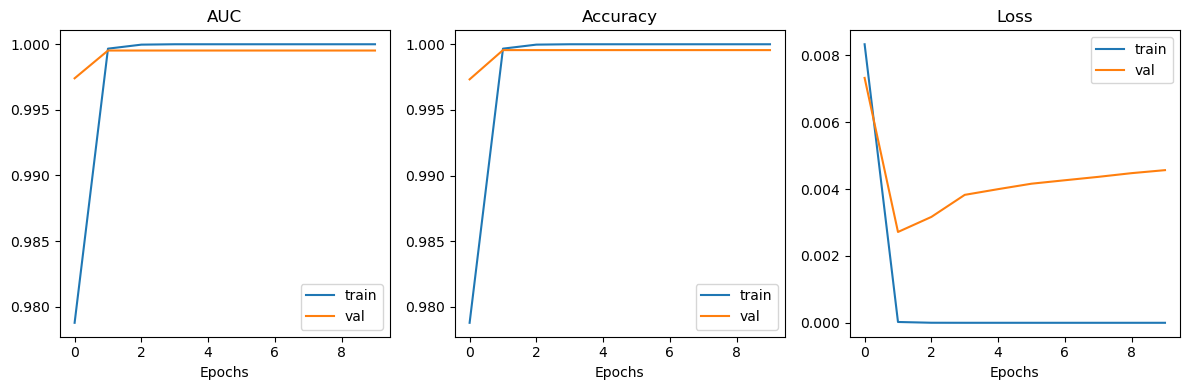

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].plot(train_aucs, label='train')
axs[0].plot(val_aucs, label='val')
axs[0].set_xlabel('Epochs')
axs[0].set_title('AUC')
axs[0].legend()

axs[1].plot(train_accs, label='train')
axs[1].plot(val_accs, label='val')
axs[1].set_xlabel('Epochs')
axs[1].set_title('Accuracy')
axs[1].legend()

axs[2].plot(train_losses, label='train')
axs[2].plot(val_losses, label='val')
axs[2].set_xlabel('Epochs')
axs[2].set_title('Loss')
axs[2].legend()

plt.tight_layout()
plt.show()

In [12]:
test_auc, test_accuracy, test_loss

(0.9995300751879699, 0.999554565701559, 0.002900876553756485)